In [3]:
import chromadb

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import numpy as np
from pypdf import PdfReader
from tqdm import tqdm

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

import umap
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv

In [5]:
def _read_pdf(filename):
    reader = PdfReader(filename)
    
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]
    return pdf_texts


def _chunk_texts(texts):
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts


def load_chroma(filename, collection_name, embedding_function):
    texts = _read_pdf(filename)
    chunks = _chunk_texts(texts)

    chroma_cliet = chromadb.Client()
    chroma_collection = chroma_cliet.create_collection(name=collection_name, embedding_function=embedding_function)

    ids = [str(i) for i in range(len(chunks))]

    chroma_collection.add(ids=ids, documents=chunks)

    return chroma_collection

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [6]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [1]:
%set_env OPENAI_API_KEY=
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

env: OPENAI_API_KEY=


NameError: name 'os' is not defined

In [9]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [01:19<00:00,  4.40it/s]


In [11]:
# projected_dataset_embeddings

In [16]:
def augment_query_generated(query,model="gpt-3.5-turbo"):
    messages = [
        {
            "role":"system",
            "content":"You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role":"user","content":query}
    ]
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages
    )
    content = response.choices[0].message.content
    return content

In [17]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

In [18]:
hypothetical_answer

'In the past fiscal year, our executive team experienced minimal turnover. Only one member of the executive leadership team departed the company, and this position was filled promptly with an internal promotion. This stability in our executive team has allowed for continuity in our strategic direction and operational excellence.'

In [19]:

joint_query = f"{original_query} {hypothetical_answer}"
joint_query

'Was there significant turnover in the executive team? In the past fiscal year, our executive team experienced minimal turnover. Only one member of the executive leadership team departed the company, and this position was filled promptly with an internal promotion. This stability in our executive team has allowed for continuity in our strategic direction and operational excellence.'

In [23]:
result = chroma_collection.query(query_texts=joint_query,n_results=5,include=["documents","embeddings"])

In [27]:
# result
retrieved_documents = result['documents'][0]

In [28]:
retrieved_embeddings = result['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])


In [29]:
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


(-6.166297650337219, 5.2590725183486935, 4.61263074874878, 10.588058567047119)

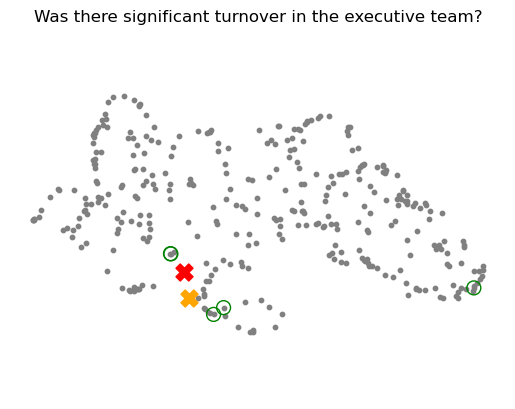

In [30]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [31]:
#######

In [42]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [33]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

In [34]:
augmented_queries

["- How did the company's marketing strategies impact revenue growth?",
 '- What new products or services were introduced that helped drive revenue?',
 '- Were there any significant changes in pricing that affected revenue?',
 '- Did the company enter new markets or expand existing ones to boost revenue?',
 '- How did changes in consumer behavior or trends influence revenue growth?']

In [35]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']


In [47]:
# retrieved_documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents  = list(unique_documents)
unique_text  = "\n".join(unique_documents)

In [49]:
# unique_text

In [52]:
def augment_output(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": f"""You are a helpful expert financial research assistant. based the below context, give the output context : {unique_text}"""
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [53]:
augment_output("What were the most important factors that contributed to increases in revenue?")

['The most important factors that contributed to increases in revenue for fiscal year 2022 included:',
 '',
 '1. Growth in Microsoft Cloud revenue, driven by Azure and other cloud services.',
 '2. Increase in productivity and business processes revenue, driven by Office 365 commercial and LinkedIn.',
 '3. Rise in more personal computing revenue, fueled by search and news advertising and Windows.',
 '4. Strong performance in search and news advertising revenue, driven by higher revenue per search and search volume.',
 '5. Gaming revenue growth, benefiting from Xbox hardware and Xbox content and services.',
 '6. Increase in Surface revenue.',
 '7. Significant growth in commercial sales, office commercial products and cloud services, and LinkedIn revenue.',
 '8. Rise in Dynamics products and cloud services revenue, primarily driven by Dynamics 365.',
 '9. Revenue increase in server products and cloud services, particularly due to Azure and other cloud services.',
 '10. Windows OEM revenue